In [1]:
import pandas as pd
from pathlib import Path
from io import StringIO
import json

- https://github.com/rafalposwiata/depression-detection-lt-edi-2022

In [2]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import load_dataset
import datasets

In [3]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

# col cuore in gola

dataset

In [4]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(Path("downloads", "task_0", f"{filename}.tsv"), "rt", encoding="utf8") as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
# dup_idx = df.index.difference(df.drop_duplicates().index)
# df.loc[dup_idx]
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")

train test indexes

In [5]:
lookup = df.set_index("old_idx")["new_idx"]
pth = Path("downloads", "task_0", "train_test_splitting.json")
idx = json.load(open(pth, "rt"))
idx = {k: [lookup[i] for i in lst if i in lookup] for k, lst in idx.items()}


In [6]:
x, y = df["pp_text"], df["label"]
x_train, x_test = x.loc[idx["train"]], x.loc[idx["test"]]
y_train, y_test = y.loc[idx["train"]], y.loc[idx["test"]]

In [7]:
dataset = {
    "train": datasets.Dataset.from_list([{"label": int(y), "text": str(x)} for y, x in zip(y_train, x_train)]),
    "test": datasets.Dataset.from_list([{"label": int(y), "text": str(x)} for y, x in zip(y_test, x_test)]),
}

dataset =  datasets.DatasetDict(dataset)

tokens

In [8]:
tokenizer = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [10]:
tokenized_datasets.items()

dict_items([('train', Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 8958
})), ('test', Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 1817
}))])

In [11]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

finetuning

In [12]:
model = AutoModelForSequenceClassification.from_pretrained("ShreyaR/finetuned-roberta-depression") # "rafalposwiata/deproberta-large-depression"

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
training_args = TrainingArguments(
    "test-trainer",
    # no_cuda=True,
    seed=42,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
)


In [14]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["eval"],
    # data_collator=data_collator, 
    # tokenizer=tokenizer,
)

In [15]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8958
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 3357
  Number of trainable parameters = 124647170


Step,Training Loss
500,0.597900
1000,0.515000
1500,0.513900
2000,0.514400
2500,0.465000
3000,0.424400


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test-trainer/checkpoint-2000
Configuration saved in test-trainer/checkpoint-2000/config.json
Model weights saved in test-trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test-trainer/checkpoint-2500
Configuration saved in test-trainer/checkpoint-2500/config.json
Model weights saved in test-trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test-trainer/checkpoint-30

TrainOutput(global_step=3357, training_loss=0.4954162770380106, metrics={'train_runtime': 3838.2776, 'train_samples_per_second': 7.002, 'train_steps_per_second': 0.875, 'total_flos': 7069267835412480.0, 'train_loss': 0.4954162770380106, 'epoch': 3.0})

In [16]:
predictions = trainer.predict(tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1817
  Batch size = 8


In [41]:
dataset["test"][-1], dataset["test"][0]

({'label': 0,
  'text': 'i liked the the writing was clearly for kids and the story cliched at times but the concept was clever and different seems like something many redditors would like '},
 {'label': 1,
  'text': 'dosage adrafinil okay it s my first time ever taking adrafinil i have looked up dosages and stuff but nothing says anything about first timers i capped my own powder just caps both were mg is this too much for a beginner ? any help is appreciated ! i weigh lbs or kg if that helps at all '})

In [23]:
import pickle

In [27]:
pickle.dump(predictions, open("predictions.pkl", "wb"))

In [34]:
y_pred = [ 1 if p < n else 0 for p, n in predictions[0]]
y_true = predictions[1]

metrics

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

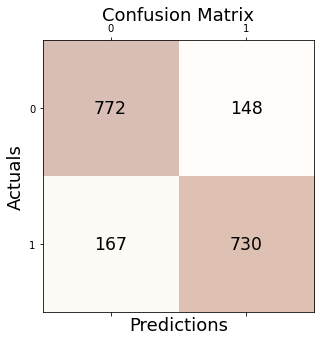

In [38]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [40]:
print('Precision:', precision_score(y_true, y_pred))
print('Recall: ', recall_score(y_true, y_pred))
print('Accuracy: ',  accuracy_score(y_true, y_pred))
print('F1 Score: ',  f1_score(y_true, y_pred))

Precision: 0.8314350797266514
Recall:  0.8138238573021181
Accuracy:  0.8266373142542652
F1 Score:  0.8225352112676055
